In [1]:
# Import necessary libraries
import numpy as np
from skimage.transform import resize
from skimage.io import imread
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pandas as pd
from skimage.transform import resize
from skimage.io import imread

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay
)

import matplotlib.pyplot as plt
import seaborn as sns

RANDOM_STATE = 42
IMG_SIZE = (150, 150, 3)


In [2]:
target = []
images = []   # In matrix format
flat_data = []  # In vector format

datadir = '../Data/AppleData'
categories = ['Apple___Apple_scab',
              'Apple___Black_rot',
              'Apple___Cedar_apple_rust',
              'Apple___healthy',
              'Background_without_leaves']

for category in categories:
  path= datadir + '/' + category
  for img in os.listdir(path):
    img_matrix=imread(os.path.join(path,img))
    img_resized=resize(img_matrix,(150,150,3))
    flat_data.append(img_resized.flatten())
    images.append(img_resized)
    target.append(category)

In [3]:
import pandas as pd
df=pd.DataFrame(flat_data)
df['Target']=target

In [4]:
# Cell 3: Train/test split

X = df.iloc[:, :-1].values
y = df['Target'].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=RANDOM_STATE
)

print("Train size:", X_train.shape)
print("Test size:", X_test.shape)
pd.Series(y_train).value_counts()


Train size: (4630, 67500)
Test size: (1158, 67500)


Apple___healthy              1316
Background_without_leaves     914
Apple___Apple_scab            800
Apple___Cedar_apple_rust      800
Apple___Black_rot             800
Name: count, dtype: int64

In [5]:
# Cell 4: Decision Tree + GridSearchCV

param_grid = {
    "max_depth": [5, 10, 20, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "criterion": ["gini"]
}

dt = DecisionTreeClassifier(random_state=RANDOM_STATE)

cv = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=RANDOM_STATE
)

grid_search = GridSearchCV(
    estimator=dt,
    param_grid=param_grid,
    cv=cv,
    scoring="accuracy",
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

print("Best CV accuracy:", grid_search.best_score_)
print("Best parameters:", grid_search.best_params_)

best_dt = grid_search.best_estimator_


Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best CV accuracy: 0.6725701943844492
Best parameters: {'criterion': 'gini', 'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 2}


In [6]:
# Cell 5: Evaluate best Decision Tree on test set

y_pred = best_dt.predict(X_test)

test_accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {test_accuracy:.4f}\n")

print("Classification Report:")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred, labels=categories)

cm_df = pd.DataFrame(cm, index=categories, columns=categories)
cm_df


Test Accuracy: 0.6796

Classification Report:
                           precision    recall  f1-score   support

       Apple___Apple_scab       0.50      0.55      0.52       200
        Apple___Black_rot       0.69      0.58      0.63       200
 Apple___Cedar_apple_rust       0.70      0.76      0.73       200
          Apple___healthy       0.69      0.73      0.71       329
Background_without_leaves       0.81      0.74      0.77       229

                 accuracy                           0.68      1158
                macro avg       0.68      0.67      0.67      1158
             weighted avg       0.68      0.68      0.68      1158



,Apple___Apple_scab,Apple___Black_rot,Apple___Cedar_apple_rust,Apple___healthy,Background_without_leaves
Apple___Apple_scab,109,13,17,46,15
Apple___Black_rot,28,116,18,32,6
Apple___Cedar_apple_rust,16,15,152,12,5
Apple___healthy,32,22,20,240,15
Background_without_leaves,31,2,10,16,170


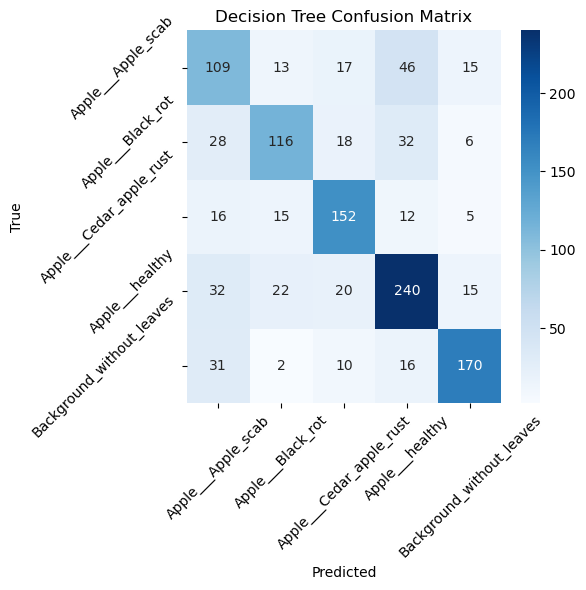

In [7]:
# Cell 6: Confusion matrix plot

plt.figure(figsize=(6,6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Decision Tree Confusion Matrix")
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()


In [8]:
# Cell 7: CV results table

cv_results = pd.DataFrame(grid_search.cv_results_)
cv_results_sorted = cv_results.sort_values("mean_test_score", ascending=False)

cv_results_sorted[[
    "mean_test_score",
    "std_test_score",
    "param_max_depth",
    "param_min_samples_split",
    "param_min_samples_leaf"
]].head(10)


,mean_test_score,std_test_score,param_max_depth,param_min_samples_split,param_min_samples_leaf
25,0.672570,0.012785,20,5,4
24,0.672570,0.012785,20,2,4
33,0.672570,0.012785,None,2,4
34,0.672570,0.012785,None,5,4
17,0.672354,0.015910,10,10,4
18,0.671274,0.015880,20,2,1
27,0.671274,0.015880,None,2,1
9,0.670842,0.014463,10,2,1
16,0.669546,0.013367,10,5,4
15,0.669546,0.013367,10,2,4


In [9]:
# Cell 8: Tree complexity and feature importances

print("Tree depth:", best_dt.get_depth())
print("Number of leaves:", best_dt.get_n_leaves())

importances = best_dt.feature_importances_
nonzero_importances = importances[importances > 0]

print("Non-zero feature count:", len(nonzero_importances))

# Show top 20
top_idx = np.argsort(importances)[-20:][::-1]
top_vals = importances[top_idx]

pd.DataFrame({
    "feature_index": top_idx,
    "importance": top_vals
})


Tree depth: 20
Number of leaves: 277
Non-zero feature count: 275


,feature_index,importance
0,15083,0.117717
1,67328,0.052485
2,32233,0.039069
3,13958,0.033353
4,8273,0.030646
5,37334,0.020362
6,62102,0.020002
7,26418,0.014557
8,65243,0.013999
9,32138,0.013533
